In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import mxnet as mx
from mxnet import gluon
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import math

import sys
import os
module_path = os.path.abspath(os.path.join('./'))
if module_path not in sys.path:
    sys.path.append(module_path)

## Fixing random seed

In [3]:
seed_number = 42
random.seed(seed_number)
np.random.seed(seed_number)
mx.random.seed(seed_number)

### Load example data; the data is from https://github.com/AmgadMansour/RankNET

In [4]:
data = pd.read_csv('data/example1//article_train_clean.csv',index_col=False)
print(data.shape)
data.rename(columns={'Unnamed: 0':'article_id','shared':'n_shares',}, inplace=True)
#Set article_id as index of the data frame (its values are used as labels for rows)
data.set_index('article_id',inplace=True)

(20005, 60)


In [5]:
q_col = pd.read_excel('data/example1/query_column.xlsx')
q_col = q_col['q_id'].tolist()
print(len(q_col))
data.insert(1, 'q_id',q_col)

20005


In [6]:
#making sure data is loaded correctly
#qid_1(1-24)
#qid_2(25-46)--last n_shares = 1100
#qid_3(47-..)--first n_shares = 776
art_id = 46
print(data.loc[art_id , ['n_shares', 'q_id','c1'] ])
nq = data['q_id'].nunique()  # 360 total queries

n_shares    1100.000000
q_id           2.000000
c1             0.333333
Name: 46, dtype: float64


In [7]:
X_val = data.query('1 <= q_id <= 72')
X_train = data.query('73 <= q_id <= 288')
X_test = data.query('289 <= q_id <= 360')

y_val =  X_val.loc[:,['n_shares','q_id']]
X_val = X_val.drop(["n_shares"], axis = 1)
y_train =  X_train.loc[:,['n_shares','q_id']]
X_train = X_train.drop(["n_shares"], axis = 1)
y_test =  X_test.loc[:,['n_shares','q_id']]
X_test = X_test.drop(["n_shares"], axis = 1)

# Training data prep

In [8]:
train_qid = X_train.q_id.unique()
val_qid = X_val.q_id.unique()
test_qid = X_test.q_id.unique()

data_lists = dict()

for qid in train_qid:
    data_lists[qid] = dict()
    data_lists[qid]['X'] = X_train[X_train['q_id'] == qid].drop(["q_id"], axis=1).values.astype('float32')
    data_lists[qid]['y'] = y_train[y_train['q_id'] == qid]['n_shares'].values.astype('float32')

for qid in val_qid:
    data_lists[qid] = dict()
    data_lists[qid]['X'] = X_val[X_val['q_id'] == qid].drop(["q_id"], axis=1).values.astype('float32')
    data_lists[qid]['y'] = y_val[y_val['q_id'] == qid]['n_shares'].values.astype('float32')

for qid in test_qid:
    data_lists[qid] = dict()
    data_lists[qid]['X'] = X_test[X_test['q_id'] == qid].drop(["q_id"], axis=1).values.astype('float32')
    data_lists[qid]['y'] = y_test[y_test['q_id'] == qid]['n_shares'].values.astype('float32')

In [9]:
print(len(data_lists))

360


In [10]:
from rank_utils.data import list2pairs, batcify_func
n_samples = 10000

train_pairs = []
for qid in train_qid:
    train_pairs += list2pairs(data_lists[qid]['X'], data_lists[qid]['y'], n_samples)

val_pairs = []
for qid in val_qid:
    val_pairs += list2pairs(data_lists[qid]['X'], data_lists[qid]['y'], n_samples)

print('n_train', len(train_pairs))
print('n_val', len(val_pairs))

n_train 2160000
n_val 720000


In [11]:
batch_size = 1024

train_ds = gluon.data.SimpleDataset(train_pairs)
train_iter = gluon.data.DataLoader(train_ds, batch_size=batch_size, batchify_fn=batcify_func,
                                      shuffle=True, num_workers=1, last_batch='discard')
val_ds = gluon.data.SimpleDataset(val_pairs)
val_iter = gluon.data.DataLoader(val_ds, batch_size=batch_size, batchify_fn=batcify_func,
                                    shuffle=False, num_workers=1, last_batch='discard')

# Simple training loop, from scratch

## Model definition

In [12]:
from rank_utils.models import HParamsMLP, ModelMLP, RankNet
hp = HParamsMLP(mlp_layers=[5,5])
mlp = ModelMLP(hp)
model = RankNet(mlp)

Hyperparameters:
{'mlp_act': 'softrelu',
 'mlp_layers': [5,
                5],
 'output_act': None}


## Model initialization and trainer setup

In [13]:
model_ctx = mx.cpu()  # can be mx.gpu(1), mx.gpu(2), etc
model.collect_params().initialize(mx.init.Uniform(.01), ctx=model_ctx)

In [14]:
optimizer_name = 'adam'
optimizer_settings = {'learning_rate': .001, 'wd': 0}
trainer = gluon.Trainer(model.collect_params(), optimizer_name, optimizer_settings)

## Training and evaluation loop

In [15]:
from mxnet import autograd
from tqdm import tqdm_notebook
from rank_utils.evaluations import ndcg
ndcg10 = ndcg(10)

for epoch in range(5):

    train_loss = []
    for b in tqdm_notebook(train_iter):
        with autograd.record():
            loss = model(*b)
        loss.backward()
        trainer.step(batch_size)
        train_loss.append(np.mean(loss.asnumpy()))

    train_ndcgs = []
    for qid in train_qid:
        test_score = model.scorer(mx.nd.array(data_lists[qid]['X']))
        tmp = ndcg10(y_true=data_lists[qid]['y'], y_pred=test_score.asnumpy())
        train_ndcgs.append(tmp)

    test_ndcgs = []
    for qid in val_qid:
        test_score = model.scorer(mx.nd.array(data_lists[qid]['X']))
        tmp = ndcg10(y_true=data_lists[qid]['y'], y_pred=test_score.asnumpy())
        test_ndcgs.append(tmp)

    print(
        'epoch {}: loss (train) {:.4f}; ndcg@10 (train): {:.4f}, ndcg@10 (val): {:.4f}'
        .format(epoch, np.mean(train_loss), np.mean(train_ndcgs), np.mean(test_ndcgs)))


epoch 0: loss (train) 0.8538; ndcg@10 (train): 0.3972, ndcg@10 (val): 0.4005



epoch 1: loss (train) 0.8290; ndcg@10 (train): 0.4103, ndcg@10 (val): 0.4165



epoch 2: loss (train) 0.8207; ndcg@10 (train): 0.4081, ndcg@10 (val): 0.4096



epoch 3: loss (train) 0.8167; ndcg@10 (train): 0.4091, ndcg@10 (val): 0.4082



epoch 4: loss (train) 0.8148; ndcg@10 (train): 0.4108, ndcg@10 (val): 0.4086


# Training with `model_trainer`

In [16]:
# instantiated a new model
from rank_utils.models import HParamsMLP, ModelMLP, RankNet
hp = HParamsMLP(mlp_layers=[5,5])
mlp = ModelMLP(hp)
model = RankNet(mlp)

model_ctx = mx.cpu()  # can be mx.gpu(1), mx.gpu(2), etc
model.collect_params().initialize(mx.init.Uniform(.01), ctx=model_ctx)

optimizer_name = 'adam'
optimizer_settings = {'learning_rate': .001, 'wd': 0}
trainer = gluon.Trainer(model.collect_params(), optimizer_name, optimizer_settings)

Hyperparameters:
{'mlp_act': 'softrelu',
 'mlp_layers': [5,
                5],
 'output_act': None}


In [17]:
from rank_utils.model_trainer import ModelTrainer

In [18]:
# optionally we can define a few external_eval_calls
from functools import partial
def ext_ndcg_eval(mt, tag, ndcg_func=ndcg(10)):
    if tag=='train':
        qid_list = train_qid
    elif tag=='val':
        qid_list = val_qid
    else:
        qid_list = test_qid
    
    ndcgs = []
    for qid in qid_list:
        test_score = mt.mod.scorer(mx.nd.array(data_lists[qid]['X']))
        tmp = ndcg_func(y_true=data_lists[qid]['y'], y_pred=test_score.asnumpy())
        ndcgs.append(tmp)
    return np.mean(ndcgs)

ndcg5_eval = {'name': 'ndcg@5', 
              'funcs': {'train': partial(ext_ndcg_eval, tag='train', ndcg_func=ndcg(5)),
                        'val': partial(ext_ndcg_eval, tag='val', ndcg_func=ndcg(5))                      
                       }
             }
ndcg10_eval = {'name': 'ndcg@10', 
              'funcs': {'train': partial(ext_ndcg_eval, tag='train', ndcg_func=ndcg(10)),
                        'val': partial(ext_ndcg_eval, tag='val', ndcg_func=ndcg(10))                      
                       }
             }
external_eval_calls = [ndcg5_eval, ndcg10_eval]
# external_eval_calls = []

In [19]:
mt = ModelTrainer(gluon_model=model, gluon_trainer=trainer, model_ctx=model_ctx, 
                  train_iter=train_iter, val_iter=val_iter, 
                  evals_per_epoch=10,
                  external_eval_calls=external_eval_calls)

ES patience 10, LR reduce patience 3, eps 0.0001


In [20]:
mt.train()

modelmlp1_dense0_weight (5, 58)
modelmlp1_dense0_bias (5,)
modelmlp1_dense1_weight (5, 5)
modelmlp1_dense1_bias (5,)
modelmlp1_dense2_weight (1, 5)
modelmlp1_dense2_bias (1,)
total params 331
# params: 331
# embedding params: 0
# params excluding emb: 331
--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input  (1024, 58), (1024, 58), (1024, 1), (1024, 1)               0
        Activation-1                                   (1024, 5)               0
             Dense-2                                   (1024, 5)             295
        Activation-3                                   (1024, 5)               0
             Dense-4                                   (1024, 5)              30
             Dense-5                                   (1024, 1)               6
          ModelMLP-6                                   (1024, 1)               0
        Activ

E1 B1477 C16: [loss] 0.8306/0.8270 (train/val) [ndcg@5] 0.3276/0.3246 (train/val) [ndcg@10] 0.4050/0.4063 (train/val) 
Time elapsed in epoch: 18.57s. Time elapsed in eval 2.66s.
[Train: 0.93s, IntEval 1.52s, ExtEval 0.20s][Train throughput: 231282.60/s]
EarlyStopping: ES patience 9 remaining. LR patience 2 remaining. Current/best loss: 0.8270@eval16 / 0.8264@eval15
E1 B1688 C17: [loss] 0.8295/0.8262 (train/val) [ndcg@5] 0.3333/0.3295 (train/val) [ndcg@10] 0.3996/0.4048 (train/val) 
Time elapsed in epoch: 21.19s. Time elapsed in eval 2.62s.
[Train: 0.93s, IntEval 1.49s, ExtEval 0.20s][Train throughput: 233158.01/s]
EarlyStopping: best val loss 0.8262 @ current eval, params saved to /Users/ran.ding/model_results/EQJFGRB3_inharmonious-interception/EQJFGRB3_inharmonious-interception_model_ES.params
E1 B1899 C18: [loss] 0.8289/0.8259 (train/val) [ndcg@5] 0.3357/0.3239 (train/val) [ndcg@10] 0.4090/0.4078 (train/val) 
Time elapsed in epoch: 23.82s. Time elapsed in eval 2.63s.
[Train: 0.94s, I

In [21]:
mt.print_latest_metrics()

E3 B422 C32: [loss] 0.8178/0.8235 (train/val) [ndcg@5] 0.3353/0.3242 (train/val) [ndcg@10] 0.4069/0.4067 (train/val) 


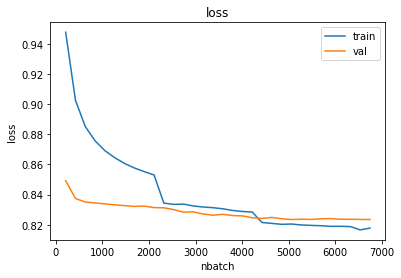

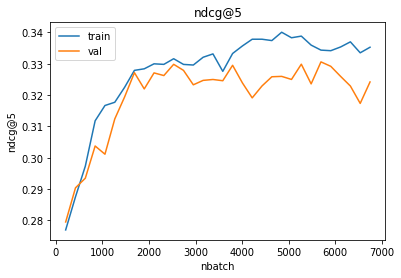

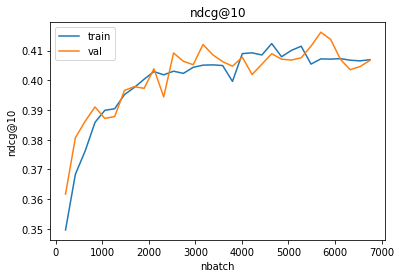

In [22]:
%matplotlib inline
mt.plot_all_metrics()

# Load trained model and make predictions on test set

In [23]:
# instantiated a new model
mlp2 = ModelMLP(hp)
model2 = RankNet(mlp2)

Hyperparameters:
{'mlp_act': 'softrelu',
 'mlp_layers': [5,
                5],
 'output_act': None}


In [24]:
mt.ES.restore_path

'/Users/ran.ding/model_results/EQJFGRB3_inharmonious-interception/EQJFGRB3_inharmonious-interception_model_ES.params'

In [25]:
model2.load_parameters(mt.ES.restore_path)

In [26]:
ndcg_func=ndcg(10)
qid_list = test_qid

ndcgs = []
for qid in qid_list:
    test_score = model2.scorer(mx.nd.array(data_lists[qid]['X']))
    tmp = ndcg_func(y_true=data_lists[qid]['y'], y_pred=test_score.asnumpy())
    ndcgs.append(tmp)
print(np.mean(ndcgs))

0.39202710051664014
